In [ ]:
# DATA VISUALIZATION USING UKRAINE RUSSIA WAR DATASET
import time
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

sns.set_style("darkgrid")


In [21]:
russia_losses_personnel = pd.read_csv('/tmp/inputs/russia_losses_personnel.csv')
russia_losses_equipment = pd.read_csv('/tmp/inputs/russia_losses_equipment.csv')
# Russia Cumulative Equipment Losses in 2022 Ukraine War
print(russia_losses_equipment.tail())

In [23]:
#dropping the last string column: 'greatest losses direction'
russia_losses_equipment.drop('greatest losses direction', axis=1, inplace=True)

#getting a string object containing the last date of data update
russia_losses_equipment['date'] = pd.to_datetime(russia_losses_equipment['date']) #converting 'date' object to datetime
last_index = len(russia_losses_equipment.index) - 1
last_date = russia_losses_equipment['date'][last_index].date().strftime("%d %B %Y")
print(f"Latest data as of {last_date}") 


Latest data as of 17 July 2023


In [24]:
#Sorting the latest data from the highest cumulative losses to lowest + Transposing to make feature columns into index
latest_day_data = russia_losses_equipment.iloc[-1:,2:].sort_values(by=[last_index],axis=1,ascending=False).T
latest_day_data.rename(columns = {last_index:'unit_amount'}, inplace = True)
print(latest_day_data.head())

#Deleting rows with unit_amount = Nan
print(latest_day_data.tail())
latest_day_data.dropna(inplace=True)
print(latest_day_data.tail())

                         unit_amount
APC                           8034.0
vehicles and fuel tanks       7059.0
field artillery               4504.0
tank                          4115.0
drone                         3828.0
                    unit_amount
helicopter                310.0
naval ship                 18.0
military auto               NaN
fuel tank                   NaN
mobile SRBM system          NaN
                       unit_amount
special equipment            677.0
anti-aircraft warfare        428.0
aircraft                     315.0
helicopter                   310.0
naval ship                    18.0


In [25]:
#Creating a list out of the latest_day_data in order to sort the chart legends from highest losses to lowest (to be done later)
number_losses_ranked_list = latest_day_data[latest_day_data.columns[0]].values.tolist()
print(number_losses_ranked_list)

equipment_names_ranked_list = latest_day_data.index.tolist() 
print(equipment_names_ranked_list)

[8034.0, 7059.0, 4504.0, 4115.0, 3828.0, 1273.0, 685.0, 677.0, 428.0, 315.0, 310.0, 18.0]
['APC', 'vehicles and fuel tanks', 'field artillery', 'tank', 'drone', 'cruise missiles', 'MRL', 'special equipment', 'anti-aircraft warfare', 'aircraft', 'helicopter', 'naval ship']


In [26]:
#Data Manipulation, categorizing units based on air, ground, or naval units.
air_units = ['drone','aircraft','helicopter', 'cruise missiles']
naval_units = ['naval ship']
ground_units = ['APC','vehicles and fuel tanks', 'tank', 'field artillery', 'MRL',  'anti-aircraft warfare', 'special equipment']
air_and_naval_units = ['drone','aircraft','helicopter', 'cruise missiles', 'naval ship']

russia_losses_equipment['Total Air Units'] = russia_losses_equipment[air_units].sum(axis=1)
russia_losses_equipment['Total Naval Units'] = russia_losses_equipment[naval_units].sum(axis=1)
russia_losses_equipment['Total Ground Units'] = russia_losses_equipment[ground_units].sum(axis=1)

#Preparing data for charts
def impute_unit(unit_name):
    if unit_name in air_units:
        return "Air Units"
    elif unit_name in naval_units:
        return "Naval Units"
    else:
        return "Ground Units"

new_df = latest_day_data
new_df.reset_index(inplace=True)
new_df = new_df.rename(columns = {'index':'equipment_name'})

#performing data manipulation, imputing categorized unit type into a new column
new_df['unit_type'] = new_df['equipment_name'].apply(lambda x: impute_unit(x))
new_df.head()


,equipment_name,unit_amount,unit_type
0,APC,8034.0,Ground Units
1,vehicles and fuel tanks,7059.0,Ground Units
2,field artillery,4504.0,Ground Units
3,tank,4115.0,Ground Units
4,drone,3828.0,Air Units


In [27]:
#Simple bar chart plot
plt.figure(figsize=(14,12))
fig = px.bar(
    new_df, x='equipment_name', y='unit_amount',text_auto=True,
    title=f'Cumulated Russian Equipment Losses in Ukraine War \n(as of {last_date})'
)
fig.update_traces(textfont_size=12, textangle=0, cliponaxis=False)
fig.update_layout(
    xaxis_title="Equipment Name",
    yaxis_title="Number of Equipment Losses"
)
fig.show()

<Figure size 1400x1200 with 0 Axes>

In [28]:
daily_total_equip_loss = russia_losses_equipment.reset_index()
daily_total_equip_loss.drop(columns={'date'}, inplace=True)
daily_total_equip_loss.set_index('day', inplace=True)
daily_total_equip_loss['Daily Total Equipment Loss'] = pd.DataFrame(daily_total_equip_loss.sum(axis=1))

plot_data2 = daily_total_equip_loss[['Daily Total Equipment Loss']]

fig=px.scatter(plot_data2, x=plot_data2.index, y='Daily Total Equipment Loss', marginal_x='box', 
               color='Daily Total Equipment Loss')

fig.update_layout(plot_bgcolor='rgba(0,5,5,0)',
                  title={'text':'Total Equipment Lost Per Day','y':0.93,'x':0.45,'xanchor':'center','yanchor':'top'})

fig.show()

In [29]:
# Getting count of total looses as of day 5
dt5 = daily_total_equip_loss.head(4).drop('Daily Total Equipment Loss', axis=1)

# Create pie chart chowing loss ratio
dict_rl_sum = dt5.sum(axis=0)[1:]
fig = go.Figure(data=[go.Pie(labels=dict_rl_sum.keys()
                             , values=dict_rl_sum.values
                             , textinfo='label'
                             , insidetextorientation='auto'
                )])
chart_title = (f'Cumulative Equipment Loss From: {russia_losses_equipment["date"].min()}  To {russia_losses_equipment["date"].max()}')
fig.update_layout(title={'text':chart_title,'y':0.85,'x':0.5,'xanchor':'center','yanchor':'top'})
fig.show()

In [30]:
# Creating bar chart based on air, ground or naval unit type
plt.figure(figsize=(14,10))
fig = px.bar(
    new_df, x='unit_type', y='unit_amount',color='equipment_name',text_auto=True,
    title=f'Cumulated Russian Equipment Losses in Ukraine War \n(as of {last_date})'
)

fig.update_layout(
    xaxis_title="Unit Type",
    yaxis_title="Number of Equipment Losses"
)
fig.show()

<Figure size 1400x1000 with 0 Axes>

In [31]:
# Among ground units, APC seems to suffer the largest casualty, followed by military auto, and then tank
# Creating pie chart containing percentages of equipment losses
plt.figure(figsize=(10,10))
categorized_df = russia_losses_equipment.iloc[-1:,-3:].sort_values(by=[last_index],axis=1,ascending=False).T
categorized_df.rename(columns = {last_index:'unit_amount'}, inplace=True)

fig = px.pie(categorized_df, values='unit_amount', names=categorized_df.index, title=f'Percentages of Cumulated Russian Equipment Losses in Ukraine War\n(as of {last_date})')
fig.show()

<Figure size 1000x1000 with 0 Axes>

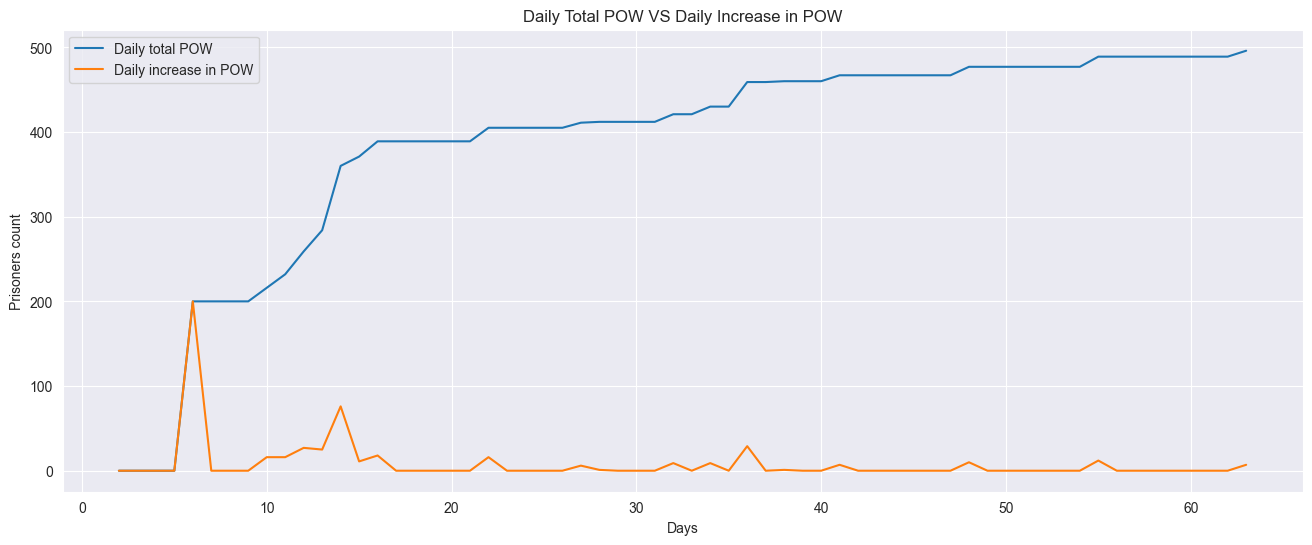

In [32]:
initial = 0
Data = []

for i in (russia_losses_personnel['POW'].values):
    value = i - initial
    Data.append(value)
    initial = i

russia_losses_personnel['Daily increase in POW'] = Data
df_personnel_structured = russia_losses_personnel[['day', 'POW', 'Daily increase in POW']].set_index('day')
df_personnel_structured.rename(columns={'POW':'Daily total POW'}, inplace=True)
#df_personnel_structured
df_personnel_structured.plot(figsize=(16,6))
plt.xlabel('Days')
plt.ylabel('Prisoners count')
plt.title("Daily Total POW VS Daily Increase in POW")
plt.show()

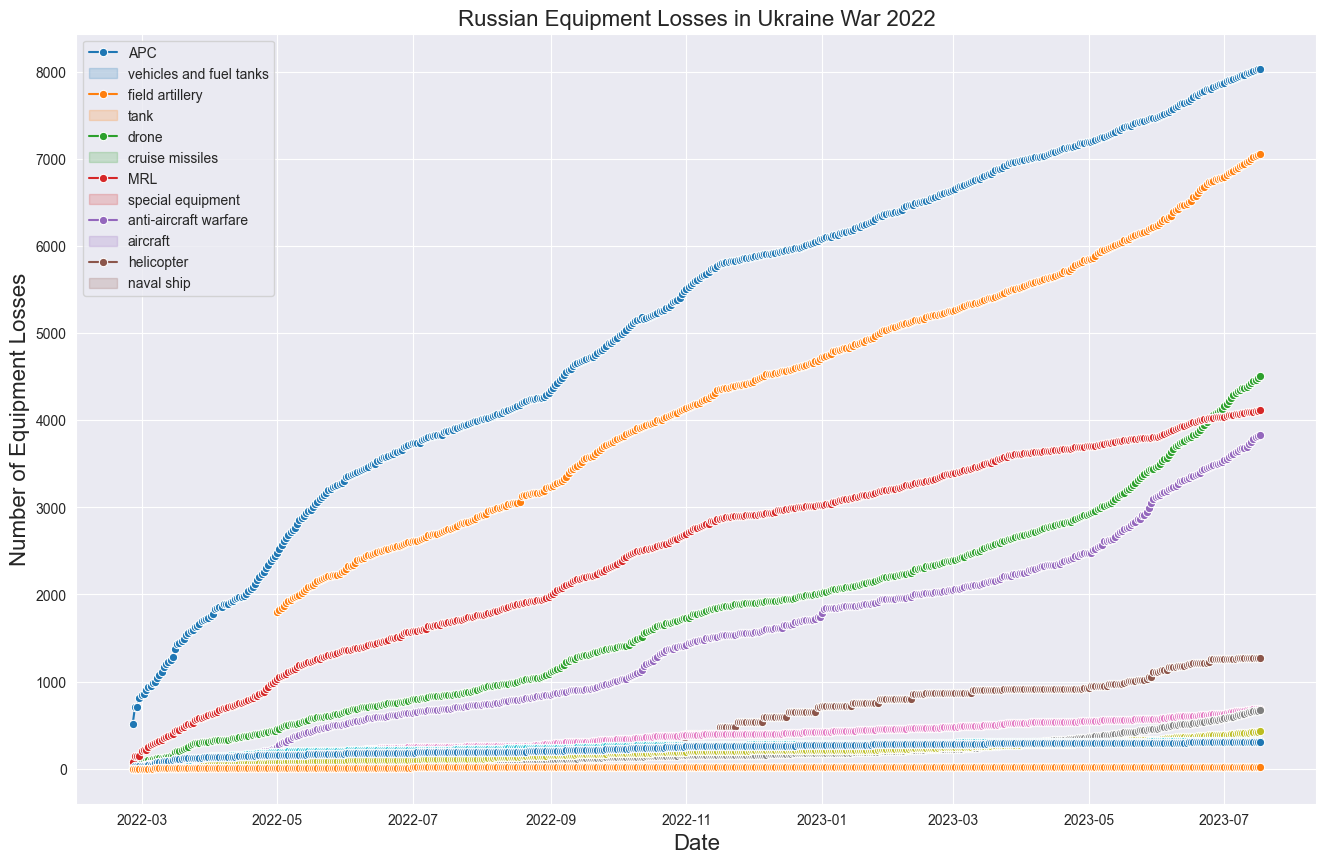

In [33]:
# Time Series of Russia Equipment Losses in 2022 Ukraine War
plt.figure(figsize=(16,10))

for equipment in equipment_names_ranked_list:
    sns.lineplot(x='date', y=equipment, data=russia_losses_equipment, marker='o')

plt.xlabel('Date',size=16)
plt.ylabel('Number of Equipment Losses',size=16)
plt.title('Russian Equipment Losses in Ukraine War 2022', size=16)
plt.legend(labels=equipment_names_ranked_list)

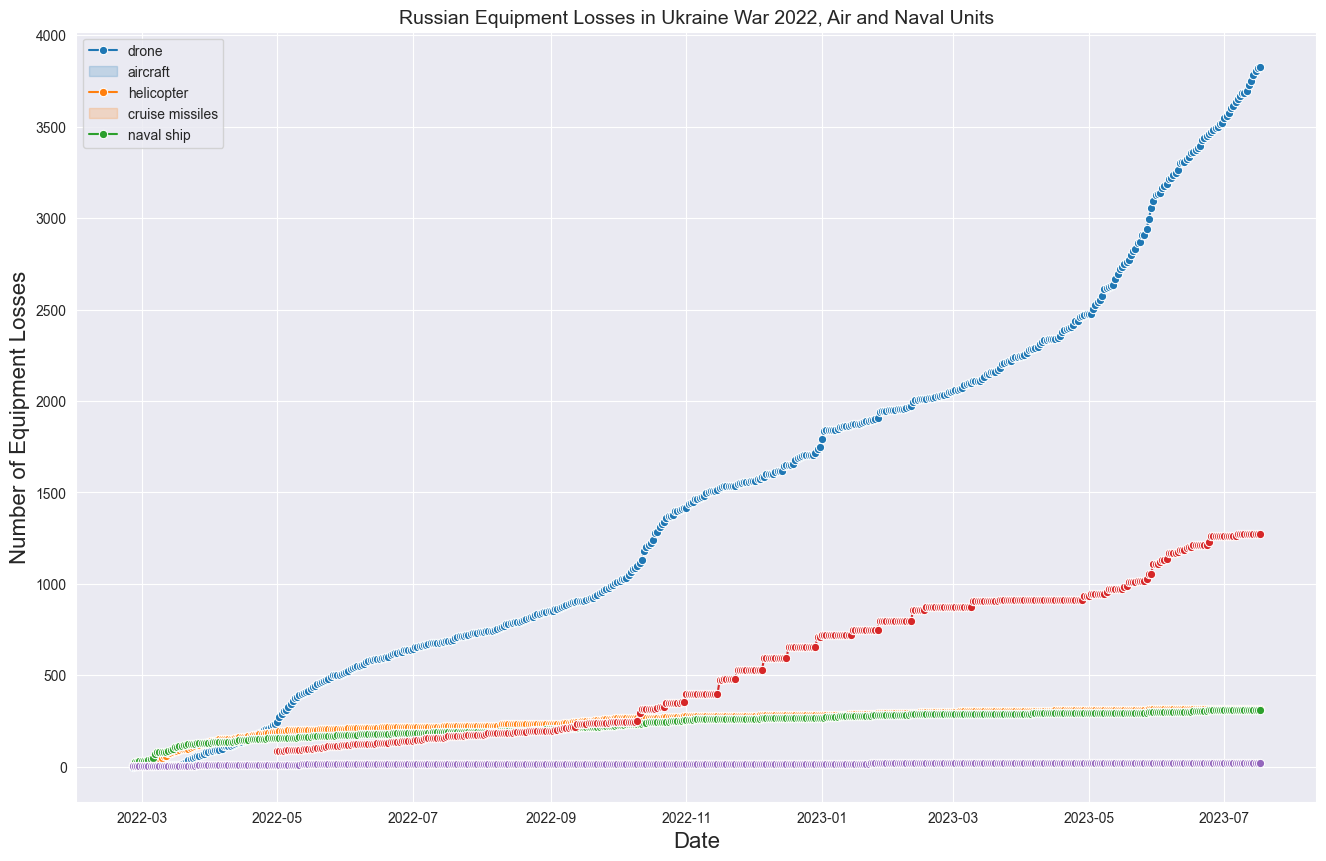

In [36]:
plt.figure(figsize=(16,10))

for unit in air_and_naval_units:
    sns.lineplot(x='date', y=unit, data=russia_losses_equipment, marker='o')

plt.xlabel('Date',size=16)
plt.ylabel('Number of Equipment Losses',size=16)
plt.title('Russian Equipment Losses in Ukraine War 2022, Air and Naval Units', size=14)
plt.legend(labels=air_and_naval_units)

In [37]:
# Time Series of Russian Personnel Casualties
print(russia_losses_personnel.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508 entries, 0 to 507
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   508 non-null    object 
 1   day                    508 non-null    int64  
 2   personnel              508 non-null    int64  
 3   personnel*             508 non-null    object 
 4   POW                    62 non-null     float64
 5   Daily increase in POW  62 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 23.9+ KB


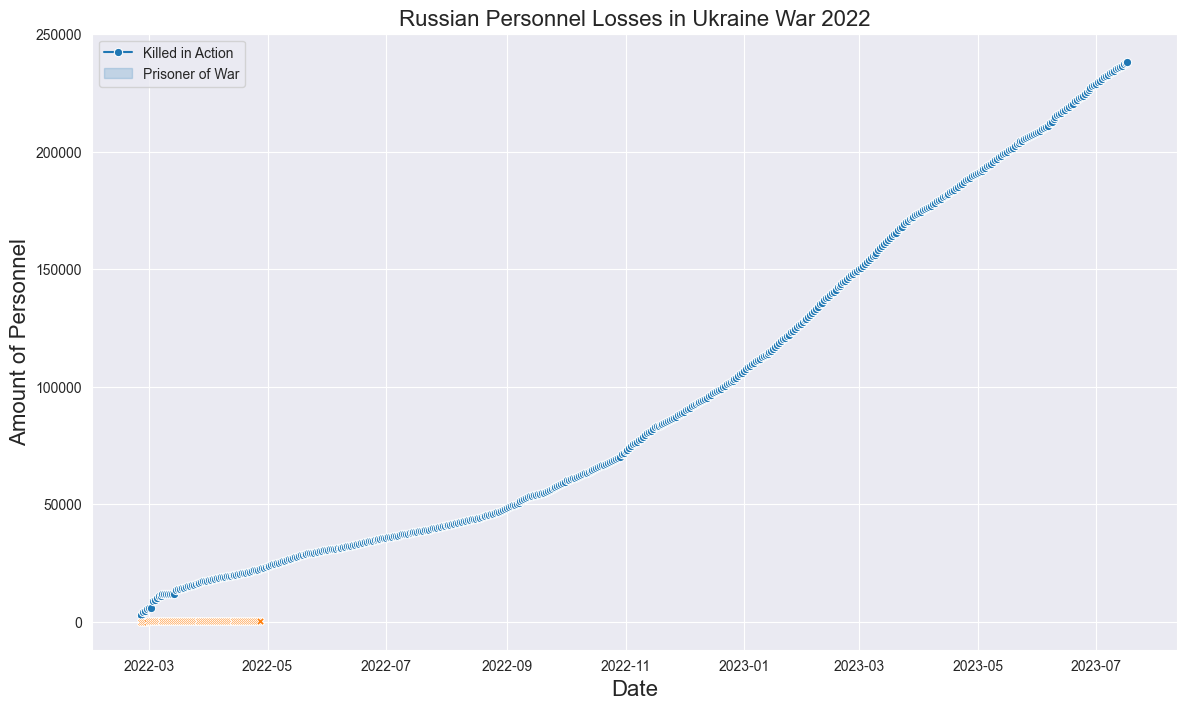

In [38]:
# There is no way to ascertain the accuracy of the data. As you can see, some of the numbers are rounded to the thousands. Despite that, lets continue on by giving the dataset the benefit of the doubt
#Converting date into datetime to get a more accurate description of the X axis
russia_losses_personnel['date']= pd.to_datetime(russia_losses_personnel['date']) 
#Plotting the data
plt.figure(figsize=(14,8))
# plt.ylim(0,13000)
sns.lineplot(x='date', y='personnel', data=russia_losses_personnel, marker='o')
sns.lineplot(x='date', y='POW', data=russia_losses_personnel ,marker='X')
plt.xlabel('Date',size=16)
plt.ylabel('Amount of Personnel',size=16)
plt.title(f'Russian Personnel Losses in Ukraine War 2022', size=16)
plt.legend(labels=['Killed in Action', 'Prisoner of War'])

In [40]:
last_index = len(russia_losses_personnel.index) - 1
latest_personnel_df = russia_losses_personnel.loc[last_index,["personnel", "POW"]]

#Creating pie chart containing percentages of russia personnel losses
plt.figure(figsize=(8,8))
fig = px.pie(latest_personnel_df, title=f'Percentages of Cumulated Russian Personnel Losses in Ukraine War\n(as of {last_date})', values=latest_personnel_df.values, names=["Killed in action","Prisoner of War"])
fig.show()

<Figure size 800x800 with 0 Axes>